1. Загрузить таблицу Mushroom из репозитория UCI (любого источника) в объект DataFrame.
Вычислить распределение значений категориальных признаков по классам (использовать pd.groupby).
Визуализировать распределения.


In [1]:
from ucimlrepo import fetch_ucirepo
mushroom = fetch_ucirepo(id=73)

X = mushroom.data.features 
y = mushroom.data.targets 


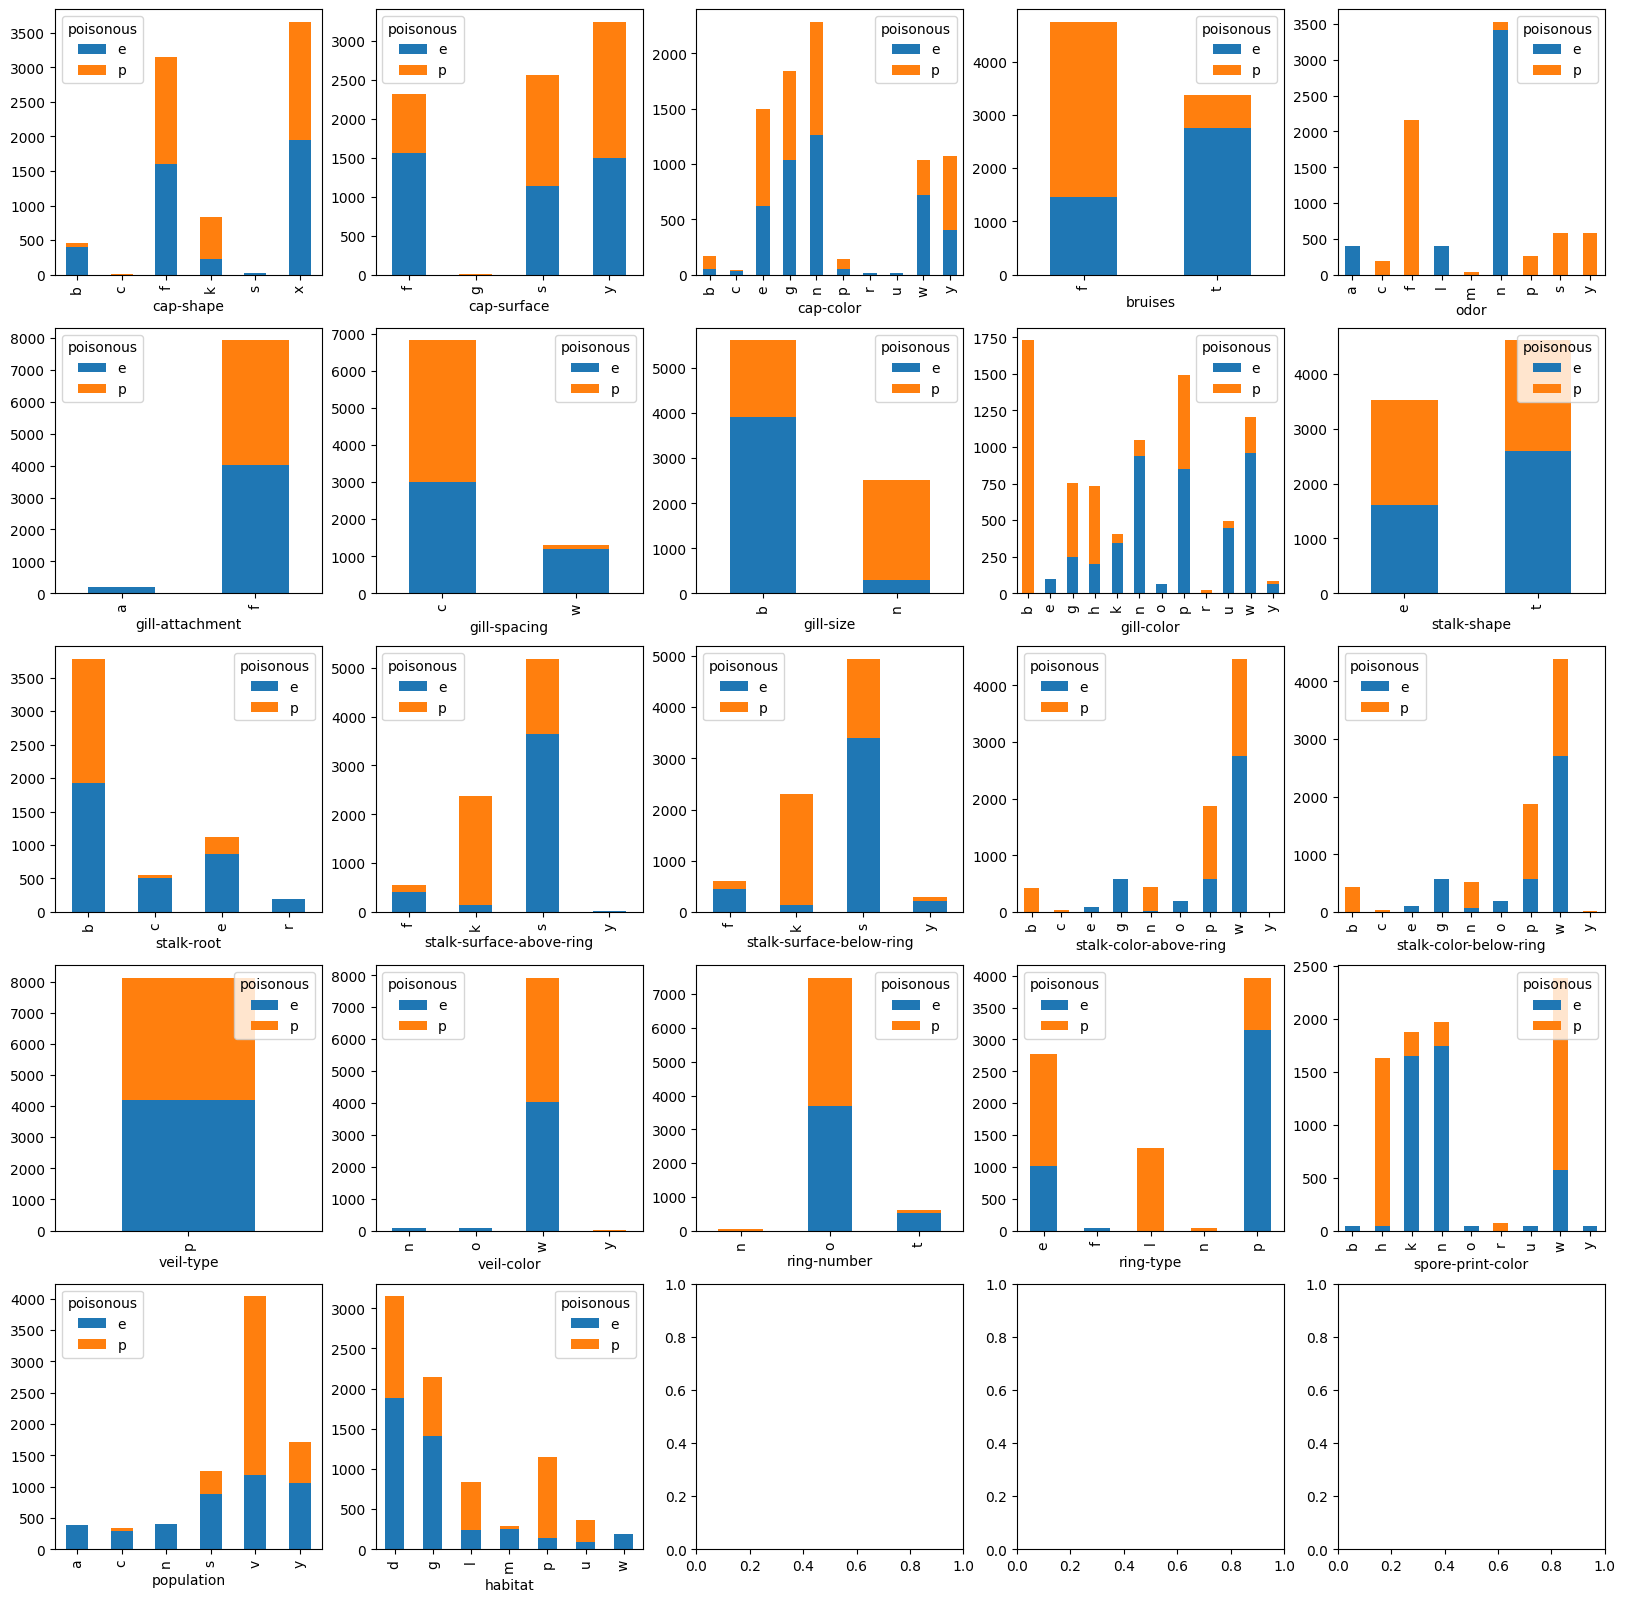

In [2]:
import pandas as pd

import matplotlib.pyplot as plt


fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.ravel()

for i, col in enumerate(X.columns):
    ct = pd.crosstab(X[col], y["poisonous"])
    ct.plot(kind="bar", stacked=True, ax=axes[i])


plt.show()


2. Построить решающую функцию по каждой переменной на основе частот. Вычислить точность каждого решения (на той же обучающей выборке). Найти наиболее информативную переменную (с минимальным числом ошибок).

In [3]:
def single_feature_predict(df, target, feature):
    mapping = df.groupby(feature)[target].agg(lambda x: x.value_counts().idxmax())
    preds = df[feature].map(mapping)
    accuracy = (preds == df[target]).mean()
    
    return accuracy

results = []

for col in X.columns:
    acc = single_feature_predict(pd.concat([X, y], axis=1), 'poisonous', col)
    results.append((col, acc))

results = sorted(results, key=lambda x: x[1], reverse=True)

best_feature, best_acc = results[0]
print(f"Наиболее информативная переменная: {best_feature}, точность: {best_acc:.3f}")


Наиболее информативная переменная: odor, точность: 0.985


3. Построить «наивный» байесовский классификатор из sklearn (выбрать правильный вариант метода). Оценить точность. 

In [ ]:
y_clean = y["poisonous"]

In [5]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

le = LabelEncoder()
y_clean = le.fit_transform(y["poisonous"])

for column in X.columns:
    X.loc[:, column] = le.fit_transform(X[column])

model = CategoricalNB()
model.fit(X, y_clean)
y_pred = model.predict(X)
confusion_matrix(y_clean, y_pred)

array([[4188,   20],
       [ 332, 3584]])

4. Самостоятельно реализовать метод, не используя готовый. Сравнить полученное решение с библиотечным. Добавить регуляризатор в оценки частот.

In [6]:
import pandas as pd
class NaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_probs = {}

    def fit(self, X, y):
        self.classes = y.unique()
        N = len(y)
        
        self.class_priors = {c: (sum(y == c) / N) for c in self.classes}

        self.feature_probs = {}
        for col in X.columns:
            self.feature_probs[col] = {}
            values = X[col].unique()
            for c in self.classes:
                subset = X[y == c]
                counts = subset[col].value_counts()
                K = len(values)
                probs = {v: (counts.get(v,0) + self.alpha) / (len(subset) + self.alpha*K) for v in values}
                self.feature_probs[col][c] = probs

    def predict(self, X):
        y = []
        for _, row in X.iterrows():
            class_scores = {}
            for c in self.classes:
                score = self.class_priors[c]    
                for col in X.columns:
                    val = row[col]
                    score *= self.feature_probs[col][c].get(
                        val, 
                        self.alpha / (self.alpha*len(self.feature_probs[col][c]))
                    )
                class_scores[c] = score
            total = sum(class_scores.values())
            probs = {c: class_scores[c]/total for c in class_scores}
            y.append(probs)

        preds = pd.DataFrame(y).idxmax(axis=1)
        return preds

    
model = NaiveBayes(alpha=0.000001)
model.fit(X, pd.Series(y_clean))
y_pred = model.predict(X)
confusion_matrix(y_clean, y_pred)


array([[4188,   20],
       [   3, 3913]])

5. Применить метод логистической регрессии, использовав в качестве переменных оценки вероятностей, подвергнутые обратному логистическому преобразованию.

In [7]:
import numpy as np

class BayessEncoder:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_probs = {}
        self.eps = 1e-15

    def fit(self, X, y):
        self.classes = y.unique()
        N = len(y)
        self.class_priors = {c: (sum(y == c) / N) for c in self.classes}

        self.feature_probs = {}
        for col in X.columns:
            self.feature_probs[col] = {}
            values = X[col].unique()
            for c in self.classes:
                subset = X[y == c]
                counts = subset[col].value_counts()
                K = len(values)
                probs = {v: (counts.get(v,0) + self.alpha) / (len(subset) + self.alpha*K) for v in values}
                probs = {v: np.log((p+self.eps) / (1-p+self.eps)) for v,p in probs.items()}
                self.feature_probs[col][c] = probs

    def transform(self, X):
        X_encoded = pd.DataFrame(index=X.index)
        for col in X.columns:
            for c in self.classes:
                probs = self.feature_probs[col][c]
                X_encoded[f"{col}_P{c}"] = X[col].map(probs)
        return X_encoded

In [8]:
from sklearn.linear_model import LogisticRegression
import numpy as np

be = BayessEncoder()
be.fit(X, pd.Series(y_clean))
logits_df = be.transform(X)

lr = LogisticRegression()
lr.fit(logits_df, pd.Series(y_clean))

y_pred = lr.predict(logits_df)

confusion_matrix(y_clean, y_pred)

array([[4208,    0],
       [   0, 3916]])